# Toronto Rental Price Prediction Project

<b> Name: </b> Gaurav Pahuja

<b> Student Number: </b> A00291777

## Objective

- Using the Toronto Rental Dataset, do some data exploration tasks such as plotting the correlation matrix for the columns.

- Feature Engineering such as localisation to district eg(Mississauga) or to specific area code

- Use scatter plots to determine outliers on this engineered feature

- Create a Model which accurately predicts the rental price

- Do Gridsearch to find the best possible model parameters

- Print the validated results

In [1]:
# Import packages
import os
import sys
import re
from importlib import reload
import imblearn
import pandas as pd
import warnings as w
import numpy as np
import json
import datetime
import time
import copy
import math
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from dython.nominal import associations
from dython.model_utils import metric_graph
from collections import Counter
import cufflinks as cf
from IPython.display import Image, display
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import statsmodels.api as sm
import sidetable as stb
import sklearn
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, matthews_corrcoef, recall_score, f1_score, \
plot_confusion_matrix, roc_auc_score, classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import tensorflow as tf
from sklearn.cluster import KMeans
from IPython.display import HTML
import folium
from branca.element import Figure
from folium import plugins
from folium.plugins import HeatMap
import plotly.express as px

In [2]:
# Jupyter notebook settings
os.environ['root'] = '/Users/greengodfitness/Desktop/College/AIT/AML/Assignment 3 - Lab Exam - A00291777/q1_toronto_rental_project'
os.chdir(os.environ['root'])
init_notebook_mode(connected=True)
sns.set(style="whitegrid")
w.filterwarnings('ignore',category=Warning)
%matplotlib inline
pd.options.display.max_columns = None

In [3]:
# Load data from csv file
df = pd.read_csv('data/Toronto_apartment_rentals_2018.csv')

In [4]:
df

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,"$2,450.00"
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,"$2,150.00"
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,"$1,950.00"
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,"$2,900.00"
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,"$1,800.00"
...,...,...,...,...,...,...,...
1119,3,1.0,0,", L7S 1R7, Burlington, ON",43.325233,-79.802182,"$3,000.00"
1120,1,1.0,0,", oakville L6M3V5 ON, Canada",43.445426,-79.736833,"$1,200.00"
1121,1,1.0,0,"Upper Beaches, Toronto, ON, Canada, M4C 1B4",43.683386,-79.309409,"$1,800.00"
1122,2,1.0,0,", Toronto M5B 2L7 ON, Canada",43.653636,-79.380873,"$2,200.00"


## Data Understanding and Data Preprocessing

In [5]:
# Mapping types based on the data
df['Bedroom'] = df['Bedroom'].astype('int64')
df['Bathroom'] = df['Bathroom'].astype('int64')
df['Den'] = df['Den'].astype('int64')
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

### Feature Engineering

#### Forward Sortation Area Clusters By Population

In [6]:
df1 = copy.deepcopy(df)
df1['FSA'] = df1['Address'].str.extract(r'([A-Z]\d+[A-Z])')
df1

,Bedroom,Bathroom,Den,Address,Lat,Long,Price,FSA
0,2,2,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,2450.0,L5B
1,1,1,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,2150.0,M5V
2,1,1,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,1950.0,M5B
3,2,2,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,2900.0,M5J
4,1,1,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,1800.0,M5T
...,...,...,...,...,...,...,...,...
1119,3,1,0,", L7S 1R7, Burlington, ON",43.325233,-79.802182,3000.0,L7S
1120,1,1,0,", oakville L6M3V5 ON, Canada",43.445426,-79.736833,1200.0,L6M
1121,1,1,0,"Upper Beaches, Toronto, ON, Canada, M4C 1B4",43.683386,-79.309409,1800.0,M4C
1122,2,1,0,", Toronto M5B 2L7 ON, Canada",43.653636,-79.380873,2200.0,M5B


Population data sourced from Statistics Canada:
https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/comprehensive.cfm

In [7]:
population = pd.read_csv('data/population_statistics_canada.csv')
del population['GeographicCode']
population

,FSA,Population,Dwellings,Residents
0,A0A,46587,26155,19426
1,A0B,19792,13658,8792
2,A0C,12587,8010,5606
3,A0E,22294,12293,9603
4,A0G,35266,21750,15200
...,...,...,...,...
1636,X0G,500,210,164
1637,X1A,20054,8093,7318
1638,Y0A,1641,1002,742
1639,Y0B,6561,4870,3122


In [8]:
dataset = pd.merge(df1, population, how = 'left', on = 'FSA')
dataset

,Bedroom,Bathroom,Den,Address,Lat,Long,Price,FSA,Population,Dwellings,Residents
0,2,2,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,2450.0,L5B,63394.0,26478.0,24822.0
1,1,1,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,2150.0,M5V,49195.0,35058.0,30726.0
2,1,1,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,1950.0,M5B,12785.0,8249.0,7058.0
3,2,2,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,2900.0,M5J,14545.0,9913.0,8649.0
4,1,1,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,1800.0,M5T,17748.0,9480.0,8537.0
...,...,...,...,...,...,...,...,...,...,...,...
1119,3,1,0,", L7S 1R7, Burlington, ON",43.325233,-79.802182,3000.0,L7S,12191.0,6322.0,6106.0
1120,1,1,0,", oakville L6M3V5 ON, Canada",43.445426,-79.736833,1200.0,L6M,65493.0,20788.0,20345.0
1121,1,1,0,"Upper Beaches, Toronto, ON, Canada, M4C 1B4",43.683386,-79.309409,1800.0,M4C,46866.0,20178.0,19431.0
1122,2,1,0,", Toronto M5B 2L7 ON, Canada",43.653636,-79.380873,2200.0,M5B,12785.0,8249.0,7058.0


### Missing Values

<b>Handling Missing Values:</b> Values in 'Population', 'Dwellings' AND 'Residents' columnS are filled based on average value of the column. (Total Missing: 60 - 0.05%)

In [9]:
# Checking if there are any missing values in the dataset
dataset.stb.missing()

,Missing,Total,Percent
Population,60,1124,0.053381
Dwellings,60,1124,0.053381
Residents,60,1124,0.053381
FSA,59,1124,0.052491
Bedroom,0,1124,0.000000
Bathroom,0,1124,0.000000
Den,0,1124,0.000000
Address,0,1124,0.000000
Lat,0,1124,0.000000
Long,0,1124,0.000000


As it is an outside data source and might not have link with our main data so we just fill in the missing values based on average.

In [10]:
# Filling Missing Values
# dataset[dataset.isnull().any(axis=1)]
dataset['Population'] = dataset['Population'].fillna(dataset['Population'].mean()).astype('int64')
dataset['Dwellings'] = dataset['Dwellings'].fillna(dataset['Dwellings'].mean()).astype('int64')
dataset['Residents'] = dataset['Residents'].fillna(dataset['Residents'].mean()).astype('int64')
dataset['FSA'] = dataset['FSA'].fillna('Unknown')

#### K-Means Clusters

Unsupervised learning is a type of machine learning in which the algorithm is not provided with any pre-assigned labels or scores for the training data. As a result, unsupervised learning algorithms must first self-discover any naturally occurring patterns in that training data set.

Cluster based on below factors that explains the demand based on below factors and how does that impact the price:
- Population
- Dwellings
- Residents

The elbow method is used to determine k, this entails looking at a line graph that shows as more centroids are added the breadth of data around those centroids decreases. The breadth of the data is called distortion or sum of square errors. Distortion could decrease rapidly at first then slowly flatten forming a bend/elbow in the line graph. This technique is used to determine an appropiate k and then perform a clustering of the census attributes.

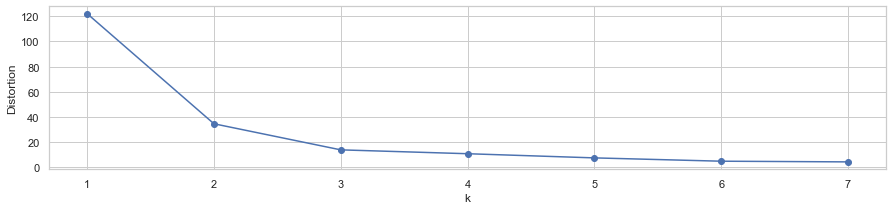

In [11]:
clust_df = copy.deepcopy(dataset)
# Removing unwanted columns and selecting columns for creating clusters
scaler = MinMaxScaler()
clust_df1 = scaler.fit_transform(clust_df[['Population', 'Dwellings', 'Residents']])
X=clust_df1
distorts = []
for i in range(1, 8):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distorts.append(km.inertia_)

# plot
plt.rcParams["figure.figsize"] = (15,3)
plt.plot(range(1, 8), distorts, marker='o')
plt.xlabel('k')
plt.ylabel('Distortion')

plt.show()

Based on elbow technique k = 3

In [12]:
# Creating Kmeans function to create raw clusters on our dataset as a feature for the model to train
def Kmeans(data, output='add'):
        n_clusters = 3
        db_id = data['FSA']
        del data['FSA']
        clf = KMeans(n_clusters = n_clusters, random_state=12)
        clf.fit(data)
        y_labels_train = clf.labels_
        if output == 'add':
            data['km_clusters'] = y_labels_train
        elif output == 'replace':
            data = y_labels_train[:, np.newaxis]
        else:
            raise ValueError('Output should be either add or replace')
        db = pd.concat([db_id, data], axis = 1)
        return db

clust_df1 = clust_df[['FSA', 'Population', 'Dwellings', 'Residents']]
clusters = Kmeans(data=clust_df1, output='add')
clusters['km_clusters'] = clusters['km_clusters'].astype('str')
clusters = clusters[['km_clusters']]
clust_df = clust_df[['FSA', 'Bedroom', 'Bathroom', 'Den', 'Price']]
model_dataset = pd.concat([clust_df, clusters], axis = 1)

In [13]:
model_dataset['km_clusters'].value_counts().iplot(kind='bar', 
                                    title='Clusters',
                                    xTitle='Clusters',yTitle='Houses',
                                    color='red')

In [14]:
# Removing unwanted columns and seleting overall features for model training
model_dataset = model_dataset[['FSA', 'Bedroom', 'Bathroom', 'Den', 'km_clusters', 'Price']]
model_dataset

,FSA,Bedroom,Bathroom,Den,km_clusters,Price
0,L5B,2,2,0,2,2450.0
1,M5V,1,1,1,2,2150.0
2,M5B,1,1,0,1,1950.0
3,M5J,2,2,0,1,2900.0
4,M5T,1,1,0,1,1800.0
...,...,...,...,...,...,...
1119,L7S,3,1,0,1,3000.0
1120,L6M,1,1,0,2,1200.0
1121,M4C,1,1,0,0,1800.0
1122,M5B,2,1,0,1,2200.0


### Outliers

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In theory, 99.7% of the data points of a normally distributed data set will be between +3 and -3 standard deviation away from the mean as shown in the figure below. That means that all the values with a standard deviation above 3 or below -3 will be considered as outliers.

In [15]:
model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124 entries, 0 to 1123
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FSA          1124 non-null   object 
 1   Bedroom      1124 non-null   int64  
 2   Bathroom     1124 non-null   int64  
 3   Den          1124 non-null   int64  
 4   km_clusters  1124 non-null   object 
 5   Price        1124 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 61.5+ KB


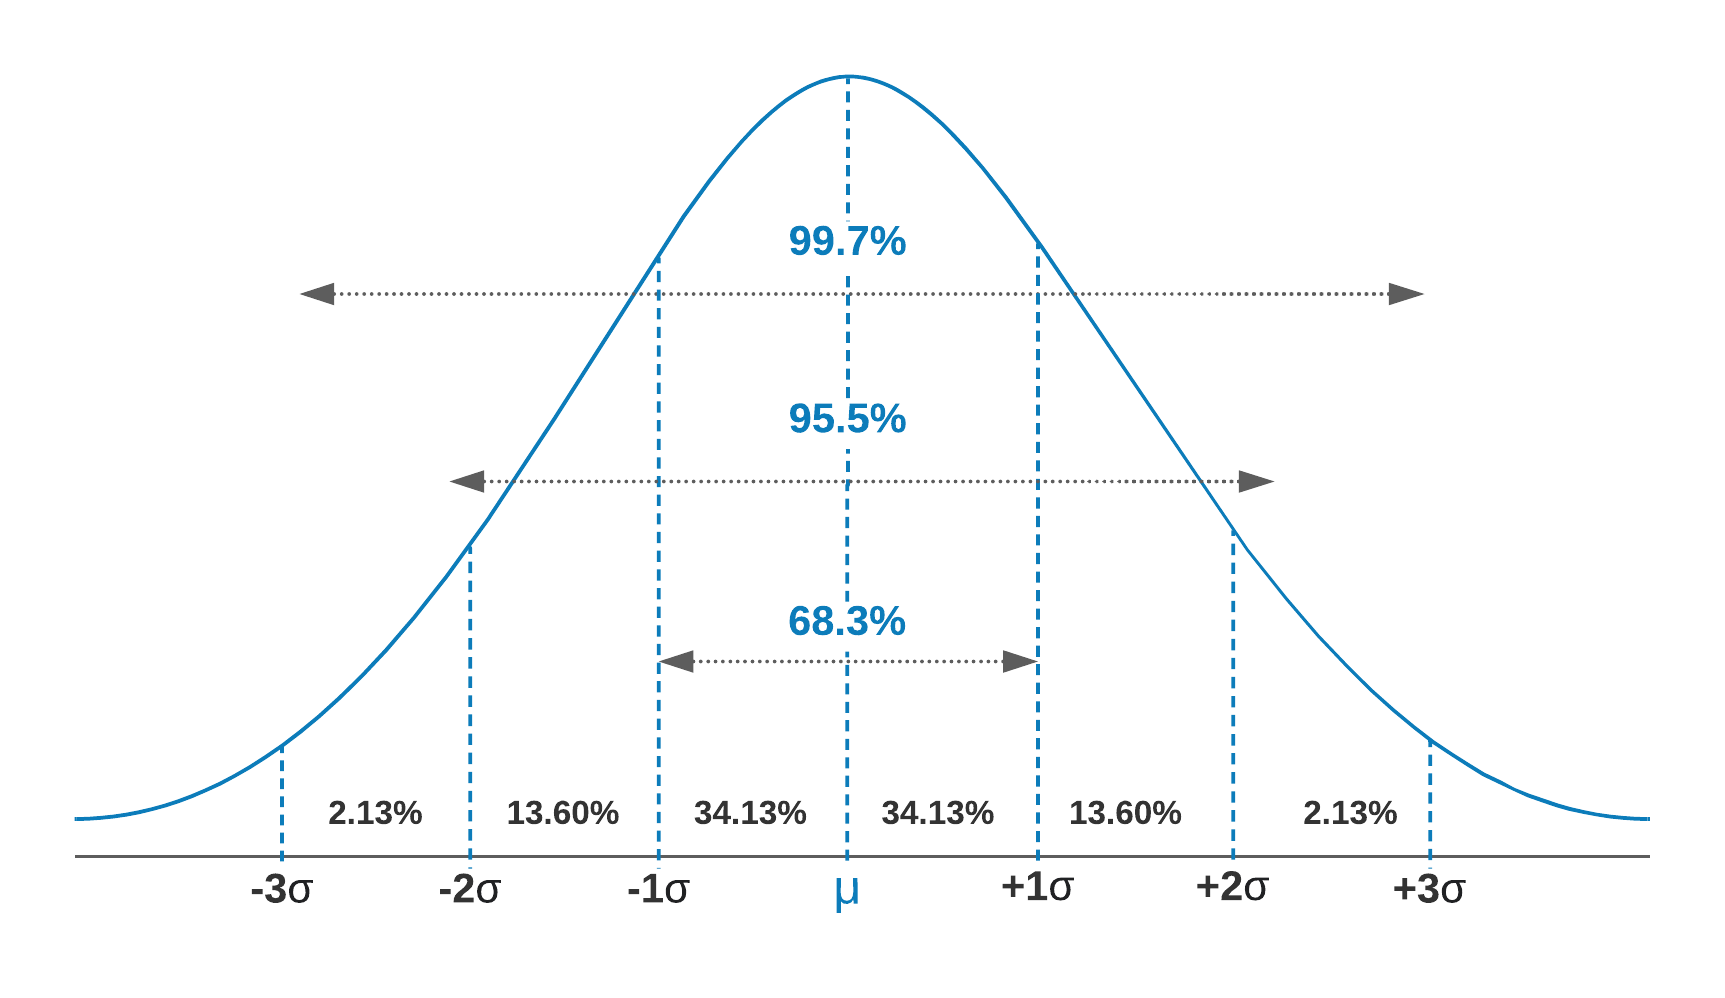

In [16]:
Image(filename='www/distribution.png') 

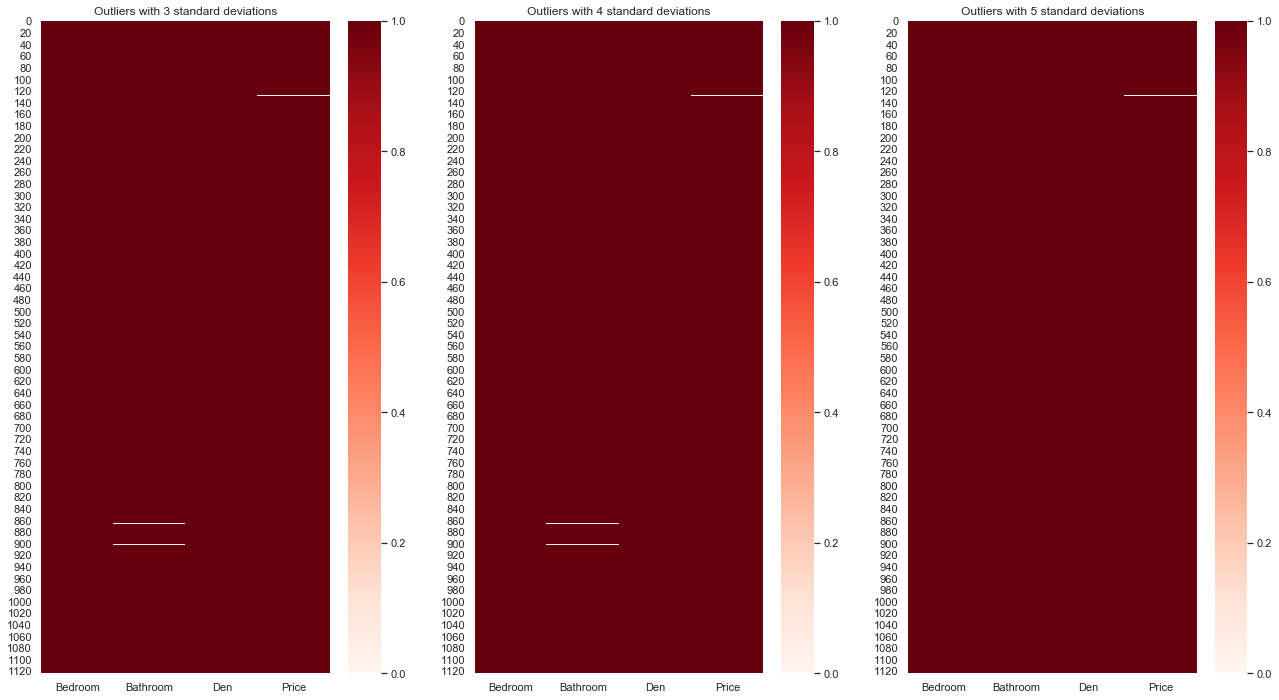

In [17]:
# Creating a heatmap to understand pattern of outliers in the dataset
df0 = copy.deepcopy(model_dataset)
columns_ = list(df0.select_dtypes(include=['int64','float64']).columns)
df0 = df0[columns_].iloc[:,0:len(columns_)]

def std_outlier(st, nstd=3.0, return_thresholds=False):
    data_mean, data_std = st.mean(), st.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [False if x < lower or x > upper else True for x in st]

std2 = df0.apply(std_outlier, nstd=3.0)
std3 = df0.apply(std_outlier, nstd=4.0)
std4 = df0.apply(std_outlier, nstd=5.0)

f, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(22, 12));
ax1.set_title('Outliers with 3 standard deviations');
ax2.set_title('Outliers with 4 standard deviations');
ax3.set_title('Outliers with 5 standard deviations');

sns.heatmap(std2, cmap='Reds', ax=ax1);
sns.heatmap(std3, cmap='Reds', ax=ax2);
sns.heatmap(std4, cmap='Reds', ax=ax3);

plt.show()

In [188]:
# Build figure to show outliers

# Data
x=model_dataset['Price']
y=model_dataset['Bedroom']

# Layout
layout = go.Layout(
    title="Outliers Based on Scatter Plot",
    xaxis=dict(
        title="Price ($)"
    ),
    yaxis=dict(
        title="Bedrooms"
    ) 
)

fig = go.Figure(layout = layout)

# Add scatter trace with medium sized markers
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=x,
        y=y,
        marker=dict(
            color='darkturquoise',
            size=6,
            opacity=0.4,
            line=dict(
                color='burlywood',
                width=1
            )
        ),
        showlegend=False
    )
)
fig.show()

In [18]:
model_dataset.describe()

,Bedroom,Bathroom,Den,Price
count,1124.000000,1124.000000,1124.000000,1124.000000
mean,1.370107,1.223310,0.153025,3627.912811
std,0.553493,0.429281,0.360172,27530.542058
min,1.000000,1.000000,0.000000,65.000000
25%,1.000000,1.000000,0.000000,1759.250000
50%,1.000000,1.000000,0.000000,2100.000000
75%,2.000000,1.000000,0.000000,2500.000000
max,3.000000,3.000000,1.000000,535000.000000


<b>Handling Outliers</b>: Values with a standard deviation above +3 or below -3 will be considered as outliers and filled in based on the interpolate function with linear values.

In [19]:
# Remove_outlier fucntion is created to remove the outliers in the dataset
def remove_outliers(skewed_dataset=df):
    columns_ = list(skewed_dataset.select_dtypes(include=['int64','float64']).columns)
    columns_.remove('Bathroom')
    str_columns = list(skewed_dataset.select_dtypes(include=['object']).columns)
    str_columns.remove('FSA')
    db_id = skewed_dataset['FSA']
    db1 = skewed_dataset[columns_]
    db2 = skewed_dataset[str_columns]
    db3 = skewed_dataset[['Bathroom']]
    z = (np.abs(stats.zscore(db1)) > 3)
    unskewed_dataset = db1.mask(z).interpolate(method = 'linear')
    db = pd.concat([db_id, db2, db3, unskewed_dataset], axis = 1)
    return db

model_dataset_ = remove_outliers(model_dataset)
model_dataset_1 = remove_outliers(model_dataset_)
model_dataset_1 = remove_outliers(model_dataset_1)

In [20]:
model_dataset_1.describe()

,Bathroom,Bedroom,Den,Price
count,1124.000000,1124.000000,1124.000000,1124.000000
mean,1.223310,1.370107,0.153025,2143.387900
std,0.429281,0.553493,0.360172,624.461064
min,1.000000,1.000000,0.000000,150.000000
25%,1.000000,1.000000,0.000000,1756.500000
50%,1.000000,1.000000,0.000000,2100.000000
75%,1.000000,2.000000,0.000000,2480.000000
max,3.000000,3.000000,1.000000,4100.000000


### Exploratory Data Analysis

In [21]:
eda_df = copy.deepcopy(model_dataset_1)

In [22]:
eda_df

,FSA,km_clusters,Bathroom,Bedroom,Den,Price
0,L5B,2,2,2,0,2450.0
1,M5V,2,1,1,1,2150.0
2,M5B,1,1,1,0,1950.0
3,M5J,1,2,2,0,2900.0
4,M5T,1,1,1,0,1800.0
...,...,...,...,...,...,...
1119,L7S,1,1,3,0,3000.0
1120,L6M,2,1,1,0,1200.0
1121,M4C,0,1,1,0,1800.0
1122,M5B,1,1,2,0,2200.0


In [200]:
df2 = dataset[dataset['Price'] <= 5000]
fig = px.scatter(df2, x='Price', y='Dwellings', hover_name='Population',
          title='Relation Between Price-Dwelling and Population', color='Population')

fig.update_traces(marker=dict(size=12,
                              line=dict(width=0.5,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

#### Spatial data

Majority of the rental properties in the dataset are based in Toronto City Centre followed by Burlington, Mississauga, Markham and Oshawa.

In [24]:
def show_map(df):
    # Creating Basemap
    fig3=Figure(width=900,height=600)
    # zoom in on toronto
    m3=folium.Map(location=[43,-79],tiles='cartodbpositron',zoom_start=6)
    fig3.add_child(m3)
    heat_data = [[row['Lat'],row['Long']] for index, row in df.iterrows()]
    # Plot it on the map
    HeatMap(heat_data,radius =3,blur=1).add_to(m3)
    # Display the map
    return m3
def save_map(amap,filename):
    amap.save(outfile= f"../html/{filename}")
    
m = show_map(df)
m

In [25]:
fig = px.histogram(eda_df, x="Price", title="House Price Distribution")
fig.show()

Majority of the houses in the dataset are with single bedroom and bathroom (Greater than 70%).

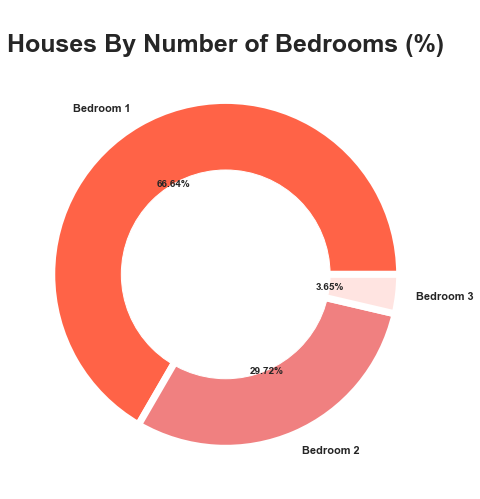

In [26]:
# assign the data
type_1   = eda_df.Bedroom.value_counts()[1]
type_2 = eda_df.Bedroom.value_counts()[2]
type_3  = eda_df.Bedroom.value_counts()[3]

names = ['Bedroom 1','Bedroom 2', 'Bedroom 3']
size  = [type_1, type_2, type_3]

# create a pie chart
plt.pie(x=size, labels=names, colors=['tomato', 'lightcoral', 'mistyrose'], 
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(15,8)
fig.gca().add_artist(circle)
plt.title('\nHouses By Number of Bedrooms (%)', fontsize=25, fontweight='bold')
plt.show()

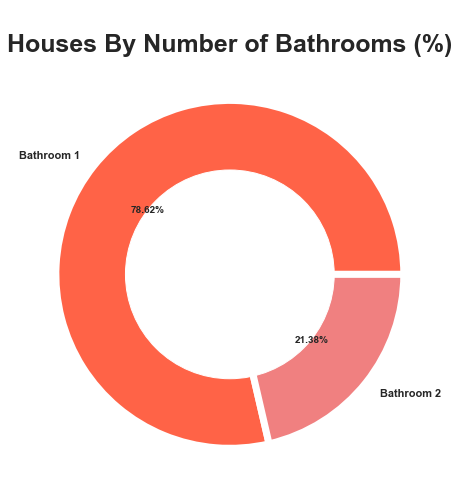

In [27]:
# assign the data
type_1   = eda_df.Bathroom.value_counts()[1]
type_2 = eda_df.Bathroom.value_counts()[2]

names = ['Bathroom 1','Bathroom 2']
size  = [type_1, type_2]

# create a pie chart
plt.pie(x=size, labels=names, colors=['tomato', 'lightcoral', 'mistyrose'], 
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(15,8)
fig.gca().add_artist(circle)
plt.title('\nHouses By Number of Bathrooms (%)', fontsize=25, fontweight='bold')
plt.show()

### Correlation

Correlation is the measure of how two features are, well, correlated; just like the month-of-the-year is correlated with the average daily temperature, and the hour-of-the-day is correlated with the amount of light outdoors. Formalising this mathematically, the definition of correlation usually used is Pearson’s R for a data sample (which results in a value in the range [-1,1]):

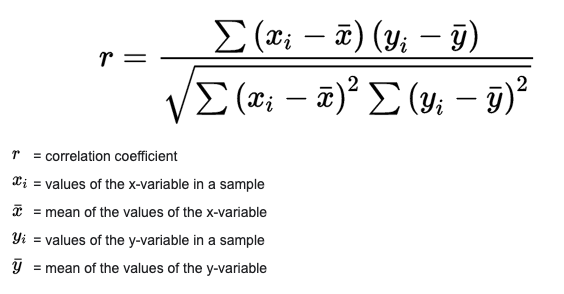

In [28]:
Image(filename='www/correlation.png') 

In [29]:
corr_df = copy.deepcopy(model_dataset_1)
del corr_df['FSA']

target = corr_df['Price']
del corr_df['Price']

numeric_columns = list(corr_df.select_dtypes(include=['int64','float64']).columns)
corr_df_f = corr_df[numeric_columns]

corr_df_1 = pd.concat([corr_df_f, target], axis = 1)

str_columns = list(corr_df.select_dtypes(include=['object']).columns)
corr_df_ = corr_df[str_columns]

corr_df_2 = pd.concat([corr_df_, target], axis = 1)

#### Integer Columns

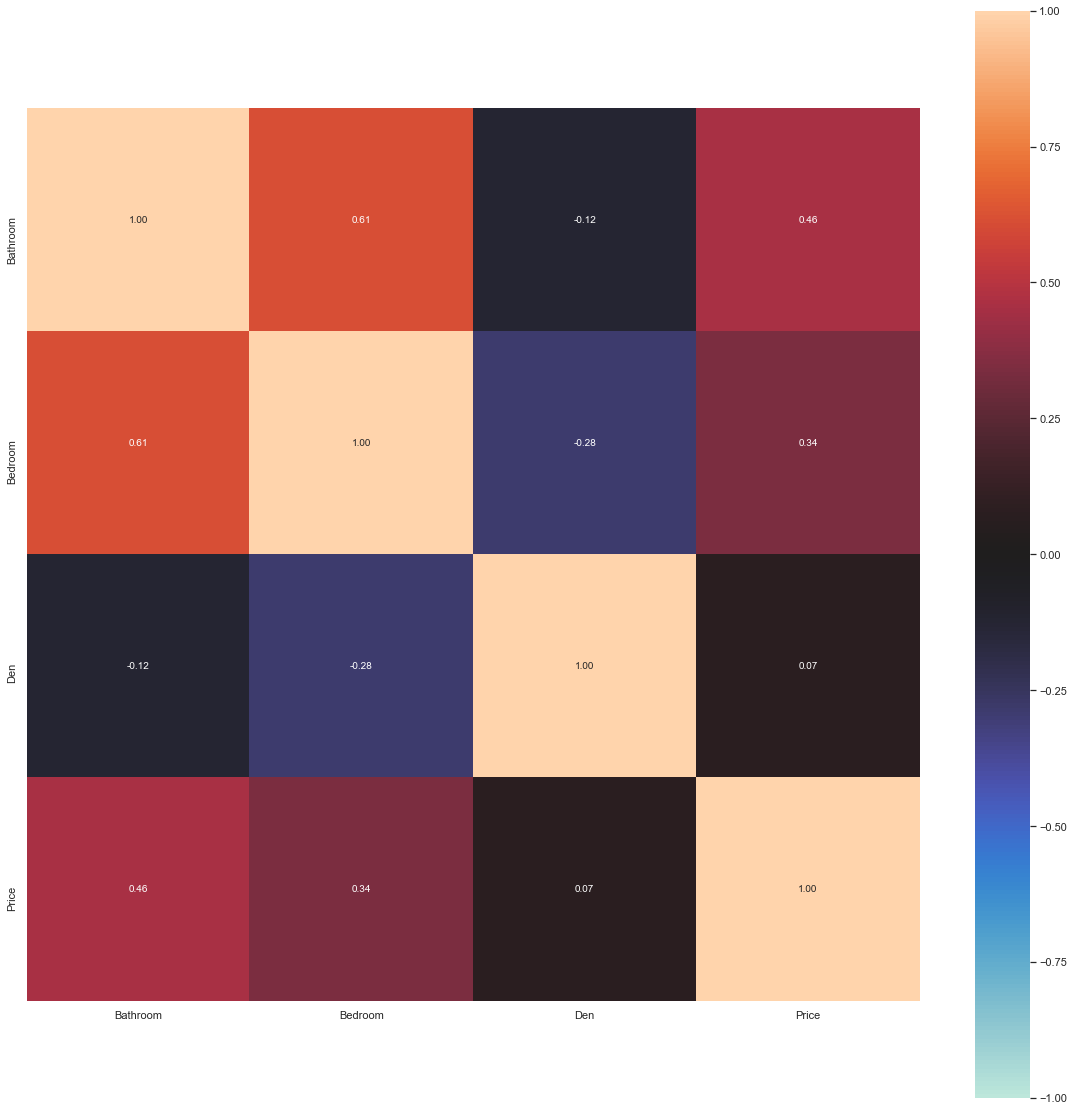

{'corr':           Bathroom   Bedroom       Den     Price
 Bathroom  1.000000  0.611264 -0.123302  0.458994
 Bedroom   0.611264  1.000000 -0.284351  0.340708
 Den      -0.123302 -0.284351  1.000000  0.073741
 Price     0.458994  0.340708  0.073741  1.000000,
 'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc6f2d36a90>}

In [30]:
associations(corr_df_1, figsize=(20, 20))

#### Theil’s U

Theil’s U, also referred to as the Uncertainty Coefficient, is based on the conditional entropy between x and y — or in human language, given the value of x, how many possible states does y have, and how often do they occur. Just like Cramer’s V, the output value is on the range of [0,1], with the same interpretations as before — but unlike Cramer’s V, it is asymmetric, meaning U(x,y)≠U(y,x) (while V(x,y)=V(y,x), where V is Cramer’s V). Using Theil’s U in the simple case above will let us find out that knowing y means we know x, but not vice-versa.

#### String Columns

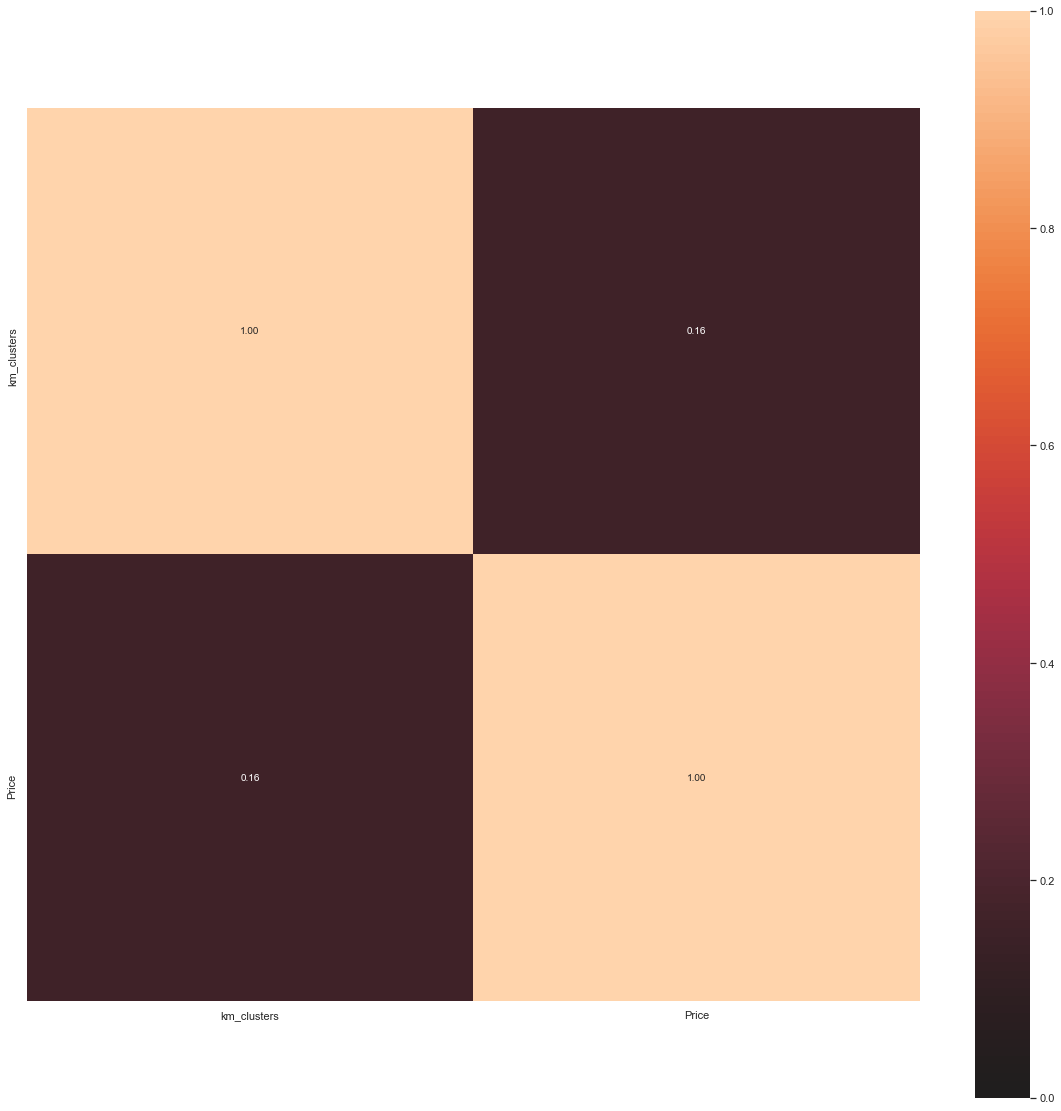

{'corr':              km_clusters     Price
 km_clusters     1.000000  0.158972
 Price           0.158972  1.000000,
 'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc713919c90>}

In [31]:
associations(corr_df_2, nom_nom_assoc='theil', figsize=(20, 20))

## Model and Technique Selection

In [32]:
model_dataset_1['Bedroom'] = model_dataset_1['Bedroom'].astype('str')
model_dataset_1['Bathroom'] = model_dataset_1['Bathroom'].astype('str')
model_dataset_1['Den'] = model_dataset_1['Den'].astype('str')
model_dataset_1

,FSA,km_clusters,Bathroom,Bedroom,Den,Price
0,L5B,2,2,2,0,2450.0
1,M5V,2,1,1,1,2150.0
2,M5B,1,1,1,0,1950.0
3,M5J,1,2,2,0,2900.0
4,M5T,1,1,1,0,1800.0
...,...,...,...,...,...,...
1119,L7S,1,1,3,0,3000.0
1120,L6M,2,1,1,0,1200.0
1121,M4C,0,1,1,0,1800.0
1122,M5B,1,1,2,0,2200.0


In [33]:
model_dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124 entries, 0 to 1123
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FSA          1124 non-null   object 
 1   km_clusters  1124 non-null   object 
 2   Bathroom     1124 non-null   object 
 3   Bedroom      1124 non-null   object 
 4   Den          1124 non-null   object 
 5   Price        1124 non-null   float64
dtypes: float64(1), object(5)
memory usage: 61.5+ KB


#### One-Hot Encoding

In [34]:
target = model_dataset_1['Price']
model_dataset_1 = model_dataset_1.drop(['Price'], axis = 1)
columns_ = list(model_dataset_1.select_dtypes(include=['int64','float64']).columns)
str_columns = list(model_dataset_1.select_dtypes(include=['object']).columns)
db1 = model_dataset_1[columns_]
db2 = pd.get_dummies(model_dataset_1[str_columns])
model_dataset_main_ = pd.concat([db1, db2, target], axis = 1)

In [35]:
test_size = 0.2
seed = 121
X = model_dataset_main_.iloc[:,:-1]
Y = model_dataset_main_.iloc[:,-1]
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, Y, test_size = test_size, 
                                                                        random_state = seed, shuffle=True)

#### Baseline Models

XGBRegressor

In [36]:
import xgboost as xgb

In [110]:
base_model = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.3, subsample=0.7, colsample_bytree=0.8)
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
scores_df = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])

R2 is: 0.36
MSE is: 258133.33
RMSE is: 342.16
Time consumed for training: 0.207 seconds
Time consumed for prediction: 0.00402 seconds


RandomForestRegressor

In [111]:
base_model = sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=7)
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.37
MSE is: 254974.83
RMSE is: 373.19
Time consumed for training: 0.218 seconds
Time consumed for prediction: 0.01080 seconds


SVR

In [112]:
base_model = sklearn.svm.SVR()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.04
MSE is: 384558.37
RMSE is: 483.63
Time consumed for training: 0.136 seconds
Time consumed for prediction: 0.03325 seconds


NuSVR

In [113]:
base_model = sklearn.svm.NuSVR()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.03
MSE is: 389254.62
RMSE is: 487.24
Time consumed for training: 0.097 seconds
Time consumed for prediction: 0.01766 seconds


SGDRegressor

In [114]:
base_model = sklearn.linear_model.SGDRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.40
MSE is: 241834.99
RMSE is: 351.13
Time consumed for training: 0.105 seconds
Time consumed for prediction: 0.00322 seconds


DecisionTreeRegressor

In [115]:
base_model = sklearn.tree.DecisionTreeRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.32
MSE is: 272390.28
RMSE is: 346.97
Time consumed for training: 0.007 seconds
Time consumed for prediction: 0.00304 seconds


ARDRegression

In [116]:
base_model = sklearn.linear_model.ARDRegression(n_iter=500)
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.39
MSE is: 245884.77
RMSE is: 351.38
Time consumed for training: 2.517 seconds
Time consumed for prediction: 0.00354 seconds


Lasso

In [117]:
base_model = sklearn.linear_model.Lasso()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.40
MSE is: 243404.23
RMSE is: 354.28
Time consumed for training: 0.007 seconds
Time consumed for prediction: 0.00366 seconds


TheilSenRegressor

In [118]:
base_model = sklearn.linear_model.TheilSenRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.39
MSE is: 245736.68
RMSE is: 353.11
Time consumed for training: 31.496 seconds
Time consumed for prediction: 0.00312 seconds


BaggingRegressor

In [119]:
base_model = sklearn.ensemble.BaggingRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.38
MSE is: 249126.45
RMSE is: 335.22
Time consumed for training: 0.045 seconds
Time consumed for prediction: 0.00695 seconds


PassiveAggressiveRegressor

In [120]:
base_model = sklearn.linear_model.PassiveAggressiveRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.43
MSE is: 231305.85
RMSE is: 336.26
Time consumed for training: 0.094 seconds
Time consumed for prediction: 0.00478 seconds


BayesianRidge

In [121]:
base_model = sklearn.linear_model.BayesianRidge()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.41
MSE is: 237878.58
RMSE is: 344.13
Time consumed for training: 0.028 seconds
Time consumed for prediction: 0.00330 seconds


KNeighborsRegressor

In [122]:
base_model = sklearn.neighbors.KNeighborsRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.34
MSE is: 265349.30
RMSE is: 374.12
Time consumed for training: 0.020 seconds
Time consumed for prediction: 0.04126 seconds


HuberRegressor

In [123]:
base_model = sklearn.linear_model.HuberRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.39
MSE is: 246348.41
RMSE is: 339.71
Time consumed for training: 0.112 seconds
Time consumed for prediction: 0.00307 seconds


GaussianProcessRegressor

In [124]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [125]:
base_model = GaussianProcessRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.32
MSE is: 272338.52
RMSE is: 346.84
Time consumed for training: 0.135 seconds
Time consumed for prediction: 0.03283 seconds


KernelRidge

In [126]:
from sklearn.kernel_ridge import KernelRidge

In [127]:
base_model = KernelRidge()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.40
MSE is: 239594.99
RMSE is: 343.81
Time consumed for training: 0.040 seconds
Time consumed for prediction: 0.00211 seconds


ExtraTreesRegressor

In [128]:
from sklearn.ensemble import ExtraTreesRegressor

In [129]:
base_model = ExtraTreesRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.32
MSE is: 273217.25
RMSE is: 347.28
Time consumed for training: 0.399 seconds
Time consumed for prediction: 0.01270 seconds


GradientBoostingRegressor

In [130]:
from sklearn.ensemble import GradientBoostingRegressor

In [131]:
base_model = GradientBoostingRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.40
MSE is: 240110.07
RMSE is: 356.83
Time consumed for training: 0.130 seconds
Time consumed for prediction: 0.00340 seconds


LassoLarsIC

In [132]:
from sklearn import linear_model

In [133]:
base_model = linear_model.LassoLarsIC()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.40
MSE is: 241437.75
RMSE is: 352.19
Time consumed for training: 0.039 seconds
Time consumed for prediction: 0.00323 seconds


ExtraTreeRegressor

In [134]:
from sklearn.tree import ExtraTreeRegressor

In [135]:
base_model = ExtraTreeRegressor()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.32
MSE is: 272175.27
RMSE is: 346.24
Time consumed for training: 0.010 seconds
Time consumed for prediction: 0.00325 seconds


Lars

In [136]:
from sklearn import linear_model

In [137]:
base_model = linear_model.LarsCV()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.36
MSE is: 257828.32
RMSE is: 382.65
Time consumed for training: 0.142 seconds
Time consumed for prediction: 0.00904 seconds


LassoLarsCV

In [138]:
from sklearn.linear_model import LassoLarsCV

In [139]:
base_model = LassoLarsCV()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.40
MSE is: 240458.22
RMSE is: 346.33
Time consumed for training: 0.167 seconds
Time consumed for prediction: 0.00326 seconds


LassoCV

In [140]:
from sklearn.linear_model import LassoCV

In [141]:
base_model = LassoCV()
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(base_model).__name__])
scores_df = scores_df.append(df2)

R2 is: 0.40
MSE is: 239569.35
RMSE is: 345.58
Time consumed for training: 0.125 seconds
Time consumed for prediction: 0.00341 seconds


### Evaluate Sampling Techniques and Models

The coefficient of discrimination, denoted 𝑅², is a commonly used performance metric for regression. It provides a measure of the proportion of the variance of a dependent variable that is explained by a regression model and defined by

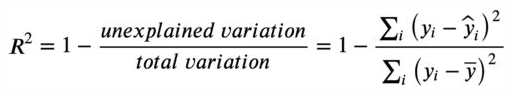

In [70]:
Image(filename='www/r2.png') 

Where 𝑦𝑖 is a dependent variable, 𝑦̂𝑖 is the output of the regression model, both indexed by 𝑖, and ӯ is the mean of the dependent variable. 𝑅² is always less than or equal to 1; the larger it is, the more the variance of the dependent variable is explained by the regression model.

In [142]:
scores_df.sort_values(by='R2_Score', ascending=False)

,R2_Score,MSE_Score,RMSE_Score
PassiveAggressiveRegressor,0.425112,231305.853193,336.260237
BayesianRidge,0.408776,237878.579498,344.134405
LassoCV,0.404574,239569.354282,345.580867
KernelRidge,0.404510,239594.987156,343.809195
GradientBoostingRegressor,0.403230,240110.066379,356.832742
LassoLarsCV,0.402365,240458.219152,346.334281
LassoLarsIC,0.399930,241437.745652,352.187732
SGDRegressor,0.398943,241834.990243,351.125207
Lasso,0.395042,243404.230234,354.277306
TheilSenRegressor,0.389245,245736.675044,353.112603


Based on the above table we can see that the top 3 performers (Regressors) on this dataset are:
- PassiveAggressiveRegressor
- BayesianRidge
- LassoCV

#### K-Fold CV

In [143]:
cv_base = sklearn.linear_model.PassiveAggressiveRegressor()
scores_base = cross_val_score(cv_base, X_train_base, y_train_base, cv=5, scoring = 'r2')
print("Scores:", scores_base)
print("Mean:", scores_base.mean())
print("Standard Deviation:", scores_base.std())

Scores: [0.40995541 0.44906874 0.45232353 0.49284126 0.49520436]
Mean: 0.45987866005408173
Standard Deviation: 0.0316250004930901


In [144]:
cv_base = sklearn.linear_model.BayesianRidge()
scores_base = cross_val_score(cv_base, X_train_base, y_train_base, cv=5, scoring = 'r2')
print("Scores:", scores_base)
print("Mean:", scores_base.mean())
print("Standard Deviation:", scores_base.std())

Scores: [0.40142654 0.45950451 0.47549563 0.46724052 0.51343149]
Mean: 0.4634197412046978
Standard Deviation: 0.03611117940759422


In [145]:
cv_base = sklearn.linear_model.LassoCV()
scores_base = cross_val_score(cv_base, X_train_base, y_train_base, cv=5, scoring = 'r2')
print("Scores:", scores_base)
print("Mean:", scores_base.mean())
print("Standard Deviation:", scores_base.std())

Scores: [0.41662934 0.44481334 0.46692442 0.45529822 0.51347595]
Mean: 0.45942825492368866
Standard Deviation: 0.03174821727396584


### Boosting Based Feature Importance

In [146]:
base_model = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.3, subsample=0.7, colsample_bytree=0.8)
training_start = time.perf_counter()
base_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = base_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))

R2 is: 0.36
MSE is: 258133.33
RMSE is: 342.16
Time consumed for training: 0.190 seconds
Time consumed for prediction: 0.00400 seconds


In [147]:
# Feature Importance
xgb_importances = pd.DataFrame({
    'Feature': X_train_base.columns,
    'Importance': base_model.feature_importances_
})
xgb_importances = xgb_importances.sort_values(by='Importance', ascending=False)
xgb_importances = xgb_importances.set_index('Feature')
xgb_importances

,Importance
Feature,
Bathroom_2,0.069707
FSA_M4L,0.043853
FSA_M6N,0.039775
FSA_L3Z,0.031325
FSA_L1J,0.028338
...,...
FSA_L5L,0.000000
FSA_M6R,0.000000
FSA_L5M,0.000000


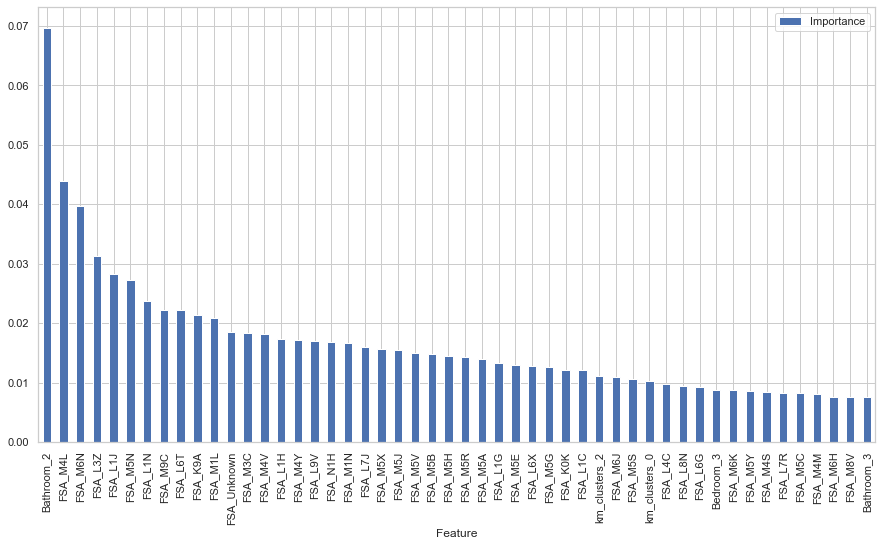

In [148]:
xgb_importances[:50].plot.bar(figsize=(15,8))

### Model Tuning

Tuning the top 2 performers to get the final model based on the baseline predictions and cross validation scores:

#### PassiveAggressiveRegressor

In [150]:
# Hyperparameter tuning for PassiveAggressiveRegressor Model through randomised search
reg = sklearn.linear_model.PassiveAggressiveRegressor()
params = {
        'shuffle': [True, False],
        'max_iter': [100, 500, 1000],
        'early_stopping': [True, False],
        'warm_start': [True, False],
        'C': [0.1, 0.3, 1]
    }

random_search = RandomizedSearchCV(reg, params, cv=5, n_iter=300, verbose=1)
start = time.time()
random_search.fit(X_train_base,
                  y_train_base)
best_parameters = random_search.best_params_
print('RandomizedSearchCV Results: ')
print(random_search.best_score_)
print('Best Parameters: ')
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
end = time.time()
print('time elapsed: ' + str(end-start))
print(' ')
print('Best Estimator: ')
print(random_search.best_estimator_)
y_pred = random_search.predict(X_test_base)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   28.5s finished


RandomizedSearchCV Results: 
0.4662655796124783
Best Parameters: 
C: 0.3
early_stopping: False
max_iter: 1000
shuffle: False
warm_start: True
time elapsed: 28.904196739196777
 
Best Estimator: 
PassiveAggressiveRegressor(C=0.3, shuffle=False, warm_start=True)


In [153]:
# Hyperparameter tuning for PassiveAggressiveRegressor Model through grid search
reg = sklearn.linear_model.PassiveAggressiveRegressor()
params = {
        'shuffle': [True, False],
        'max_iter': [100, 300, 500],
        'early_stopping': [True, False],
        'warm_start': [True, False],
        'C': [0.1, 0.3, 1.0]
    }

random_search = GridSearchCV(reg, params, cv=5, estimator=300, verbose=1)
start = time.time()
random_search.fit(X_train_base,
                  y_train_base)
best_parameters = random_search.best_params_
print('RandomizedSearchCV Results: ')
print(random_search.best_score_)
print('Best Parameters: ')
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
end = time.time()
print('time elapsed: ' + str(end-start))
print(' ')
print('Best Estimator: ')
print(random_search.best_estimator_)
y_pred = random_search.predict(X_test_base)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomizedSearchCV Results: 
0.465823794236801
Best Parameters: 
C: 1.0
early_stopping: False
max_iter: 300
shuffle: False
warm_start: True
time elapsed: 20.281727075576782
 
Best Estimator: 
PassiveAggressiveRegressor(max_iter=300, shuffle=False, warm_start=True)


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   20.2s finished


In [155]:
par_model = sklearn.linear_model.PassiveAggressiveRegressor()
training_start = time.perf_counter()
par_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = par_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(par_model).__name__])
df2

R2 is: 0.42
MSE is: 232153.29
RMSE is: 334.14
Time consumed for training: 0.069 seconds
Time consumed for prediction: 0.00325 seconds


,R2_Score,MSE_Score,RMSE_Score
PassiveAggressiveRegressor,0.423006,232153.290957,334.138533


#### BayesianRidge

In [156]:
# Hyperparameter tuning for BayesianRidge Model through randomised search
reg = sklearn.linear_model.BayesianRidge()
params = {
        'n_iter': [100, 500, 1000],
        'normalize': [True, False],
        'alpha_1': [1e-6, 1e-8, 1e-9],
        'alpha_2': [1e-6, 1e-8, 1e-9],
        'lambda_1': [1e-6, 1e-8, 1e-9],
        'lambda_2': [1e-6, 1e-8, 1e-9]
    }

random_search = RandomizedSearchCV(reg, params, cv=5, n_iter=300, verbose=1)
start = time.time()
random_search.fit(X_train_base,
                  y_train_base)
best_parameters = random_search.best_params_
print('RandomizedSearchCV Results: ')
print(random_search.best_score_)
print('Best Parameters: ')
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
end = time.time()
print('time elapsed: ' + str(end-start))
print(' ')
print('Best Estimator: ')
print(random_search.best_estimator_)
y_pred = random_search.predict(X_test_base)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomizedSearchCV Results: 
0.4634197415644431
Best Parameters: 
alpha_1: 1e-06
alpha_2: 1e-08
lambda_1: 1e-09
lambda_2: 1e-06
n_iter: 500
normalize: False
time elapsed: 34.78405499458313
 
Best Estimator: 
BayesianRidge(alpha_2=1e-08, lambda_1=1e-09, n_iter=500)


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   34.8s finished


In [157]:
# Hyperparameter tuning for BayesianRidge Model through randomised search
reg = sklearn.linear_model.BayesianRidge()
params = {
        'n_iter': [100, 500, 1000],
        'normalize': [True, False],
        'alpha_1': [1e-6, 1e-8, 1e-9],
        'alpha_2': [1e-6, 1e-8, 1e-9],
        'lambda_1': [1e-6, 1e-8, 1e-9],
        'lambda_2': [1e-6, 1e-8, 1e-9]
    }

random_search = RandomizedSearchCV(reg, params, cv=5, estimator=300, verbose=1)
start = time.time()
random_search.fit(X_train_base,
                  y_train_base)
best_parameters = random_search.best_params_
print('RandomizedSearchCV Results: ')
print(random_search.best_score_)
print('Best Parameters: ')
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
end = time.time()
print('time elapsed: ' + str(end-start))
print(' ')
print('Best Estimator: ')
print(random_search.best_estimator_)
y_pred = random_search.predict(X_test_base)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomizedSearchCV Results: 
0.4634197415644389
Best Parameters: 
alpha_1: 1e-06
alpha_2: 1e-08
lambda_1: 1e-09
lambda_2: 1e-09
n_iter: 500
normalize: False
time elapsed: 1.335420846939087
 
Best Estimator: 
BayesianRidge(alpha_2=1e-08, lambda_1=1e-09, lambda_2=1e-09, n_iter=500)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished


In [159]:
bayesian_model = sklearn.linear_model.BayesianRidge(alpha_2=1e-08, lambda_1=1e-09, lambda_2=1e-09, n_iter=500)
training_start = time.perf_counter()
bayesian_model.fit(X_train_base, y_train_base)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction = bayesian_model.predict(X_test_base)
r2 = r2_score(y_test_base, prediction)
mse = mean_squared_error(y_test_base, prediction)
rmse = mean_absolute_error(y_test_base, prediction)
prediction_end = time.perf_counter()
train_time = training_end-training_start
prediction_time = prediction_end-prediction_start
print("R2 is: %3.2f" % (r2))
print("MSE is: %3.2f" % (mse))
print("RMSE is: %3.2f" % (rmse))
print("Time consumed for training: %4.3f seconds" % (train_time))
print("Time consumed for prediction: %6.5f seconds" % (prediction_time))
df2 = pd.DataFrame([[r2, mse, rmse]], columns=['R2_Score', 'MSE_Score', 'RMSE_Score'], 
                         index = [type(bayesian_model).__name__])
df2

R2 is: 0.41
MSE is: 237878.58
RMSE is: 344.13
Time consumed for training: 0.021 seconds
Time consumed for prediction: 0.00316 seconds


,R2_Score,MSE_Score,RMSE_Score
BayesianRidge,0.408776,237878.579499,344.134405


### Final Results

PassiveAggressiveRegressor is our top performing model which will be used in the final training:

In [ ]:
target = model_dataset_main_['Price']
del model_dataset_main_['Price']

In [178]:
prediction = par_model.predict(model_dataset_main_)
pred_df = pd.DataFrame(prediction)
pred_df.rename(columns = {0:'Prediction'}, inplace = True)

In [180]:
model_dataset_main_ = pd.concat([model_dataset_main_, target, pred_df], axis = 1)

In [181]:
model_dataset_main_

,FSA_H2X,FSA_H3H,FSA_K0K,FSA_K9A,FSA_L1A,FSA_L1C,FSA_L1G,FSA_L1H,FSA_L1J,FSA_L1N,FSA_L1V,FSA_L1W,FSA_L1X,FSA_L2E,FSA_L3P,FSA_L3R,FSA_L3S,FSA_L3T,FSA_L3Y,FSA_L3Z,FSA_L4A,FSA_L4C,FSA_L4H,FSA_L4K,FSA_L4L,FSA_L4Z,FSA_L5A,FSA_L5B,FSA_L5G,FSA_L5H,FSA_L5L,FSA_L5M,FSA_L6A,FSA_L6G,FSA_L6J,FSA_L6K,FSA_L6M,FSA_L6T,FSA_L6X,FSA_L6Z,FSA_L7J,FSA_L7P,FSA_L7R,FSA_L7S,FSA_L8N,FSA_L9V,FSA_L9W,FSA_M1L,FSA_M1N,FSA_M1T,FSA_M2J,FSA_M2K,FSA_M2M,FSA_M2N,FSA_M2R,FSA_M3A,FSA_M3C,FSA_M3H,FSA_M3J,FSA_M3N,FSA_M4B,FSA_M4C,FSA_M4E,FSA_M4J,FSA_M4K,FSA_M4L,FSA_M4M,FSA_M4R,FSA_M4S,FSA_M4T,FSA_M4V,FSA_M4W,FSA_M4X,FSA_M4Y,FSA_M5A,FSA_M5B,FSA_M5C,FSA_M5E,FSA_M5G,FSA_M5H,FSA_M5J,FSA_M5N,FSA_M5R,FSA_M5S,FSA_M5T,FSA_M5V,FSA_M5X,FSA_M5Y,FSA_M6B,FSA_M6E,FSA_M6G,FSA_M6H,FSA_M6J,FSA_M6K,FSA_M6M,FSA_M6N,FSA_M6R,FSA_M6S,FSA_M8V,FSA_M8W,FSA_M8X,FSA_M8Y,FSA_M9A,FSA_M9B,FSA_M9C,FSA_M9N,FSA_N1H,FSA_N6B,FSA_T2P,FSA_Unknown,km_clusters_0,km_clusters_1,km_clusters_2,Bathroom_1,Bathroom_2,Bathroom_3,Bedroom_1,Bedroom_2,Bedroom_3,Den_0,Den_1,Price,Prediction
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,2450.0,2459.219089
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,2150.0,2410.651391
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1950.0,2019.161222
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,2900.0,2971.351931
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1800.0,1805.315667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,3000.0,2009.926117
1120,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1200.0,1493.026869
1121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1800.0,1609.364560
1122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,2200.0,2409.280646


In [202]:
s = model_dataset_main_
trace1 = go.Scatter(x = np.arange(0, len(s.Price), 1),
                    y = s.Price,
                    mode = 'lines',
                    name = 'Price',
                    line = dict(color = ('rgb(66, 134, 244)'), width = 1))
trace2 = go.Scatter(x = np.arange(0, len(s.Prediction), 1),
                    y = s.Prediction,
                    mode = 'lines',
                    name = 'Prediction',
                    line = dict(color = ('rgb(255, 102, 102)'), width = 2))
data = [trace1, trace2]
layout = dict(title = 'Price vs Prediction', xaxis = dict(title = 'Price'), yaxis = dict(title = 'Rent'))
fig = dict(data=data, layout=layout)
iplot(fig)

In [182]:
# Final submission
submission = model_dataset_main_

In [183]:
# Save as .csv
submission.to_csv('submission.csv', index=False)